# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [49]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("/datasets/taxi.csv", parse_dates = ['datetime'], index_col = 'datetime')
data.sort_index(inplace=True)
data = data.resample('1h').sum()

In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Analysis

In [5]:
data=data.sort_values(by=['datetime'], axis=0)
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<AxesSubplot:xlabel='datetime'>

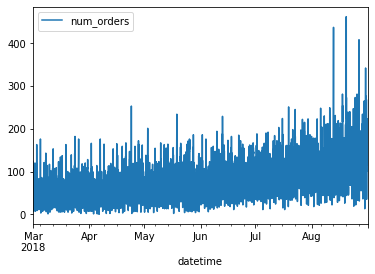

In [6]:
data.plot()

<AxesSubplot:xlabel='datetime'>

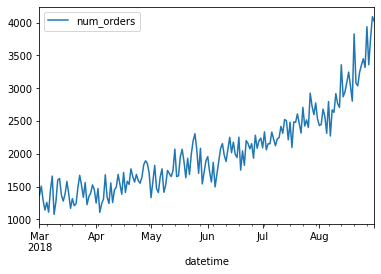

In [7]:
data.resample("1D").sum().plot()

In [8]:
df_to_plot=data['2018-08-01':'2018-08-31']

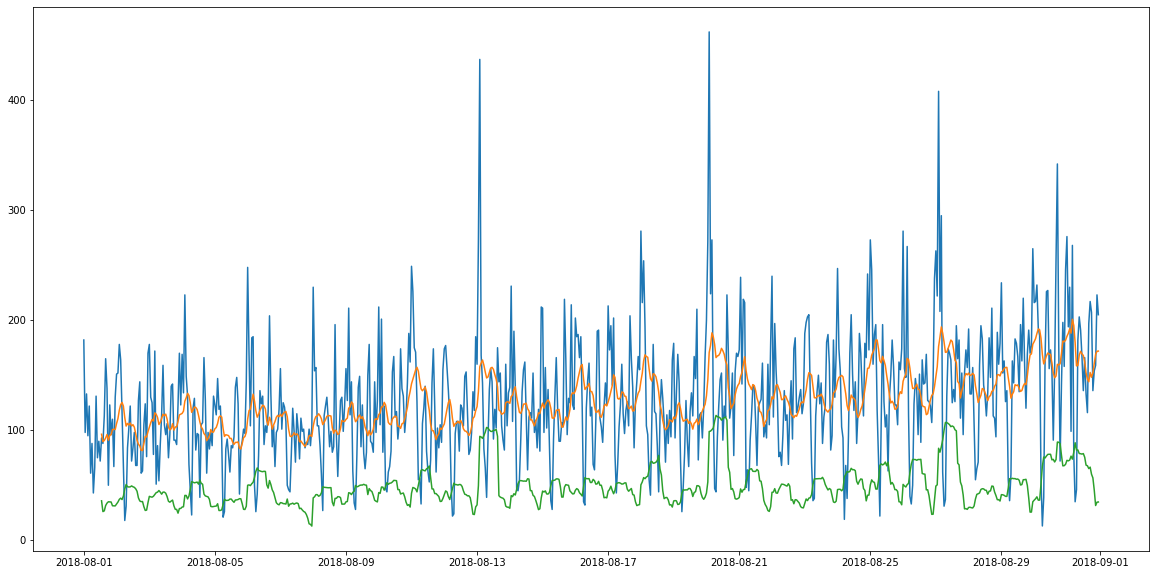

In [9]:
df_to_plot['mean'] = df_to_plot['num_orders'].rolling(14).mean()
df_to_plot['std'] = df_to_plot['num_orders'].rolling(14).std()

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111)
ax1.plot(df_to_plot)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 198.0 KB


In [11]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [12]:
data_d = data.resample("1D").sum()

In [13]:
decomposed = seasonal_decompose(data_d)

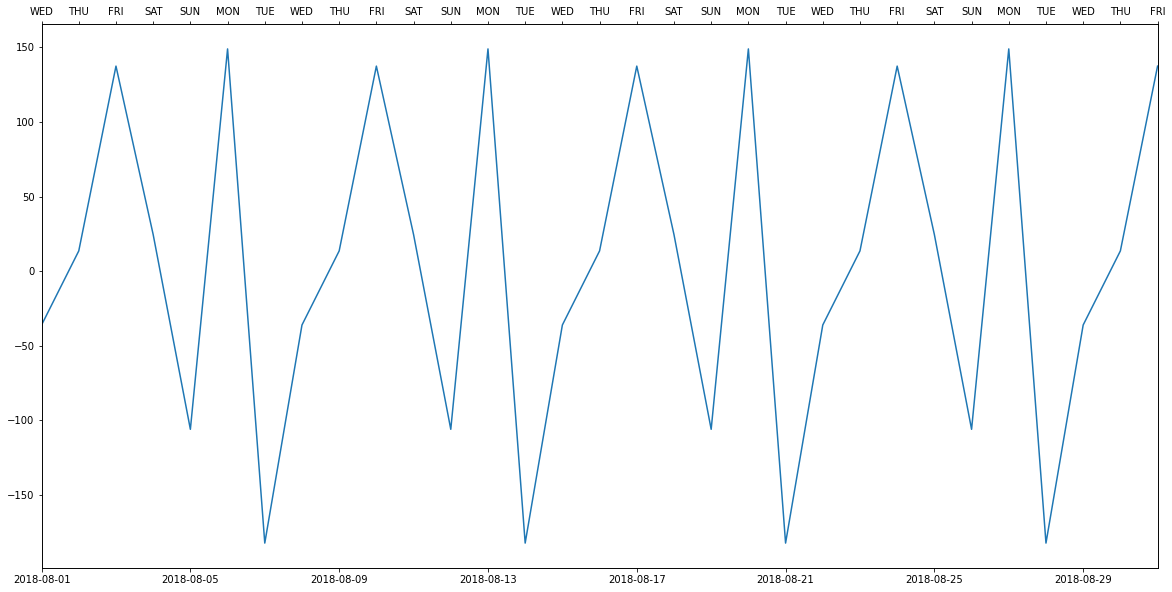

In [14]:
Y = decomposed.seasonal['2018-08-01':'2018-08-31'].values
x = decomposed.seasonal['2018-08-01':'2018-08-31'].index
weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU', 4:'FRI', 5:'SAT', 6:'SUN'}
dow = decomposed.seasonal['2018-08-01':'2018-08-31'].index.dayofweek.map(weekday_map)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax2.set_xticks(np.arange(len(x)), minor=False)
ax2.set_xticklabels(dow)
ax1.set_xlim(min(x), max(x))
ax1.plot(x, Y)

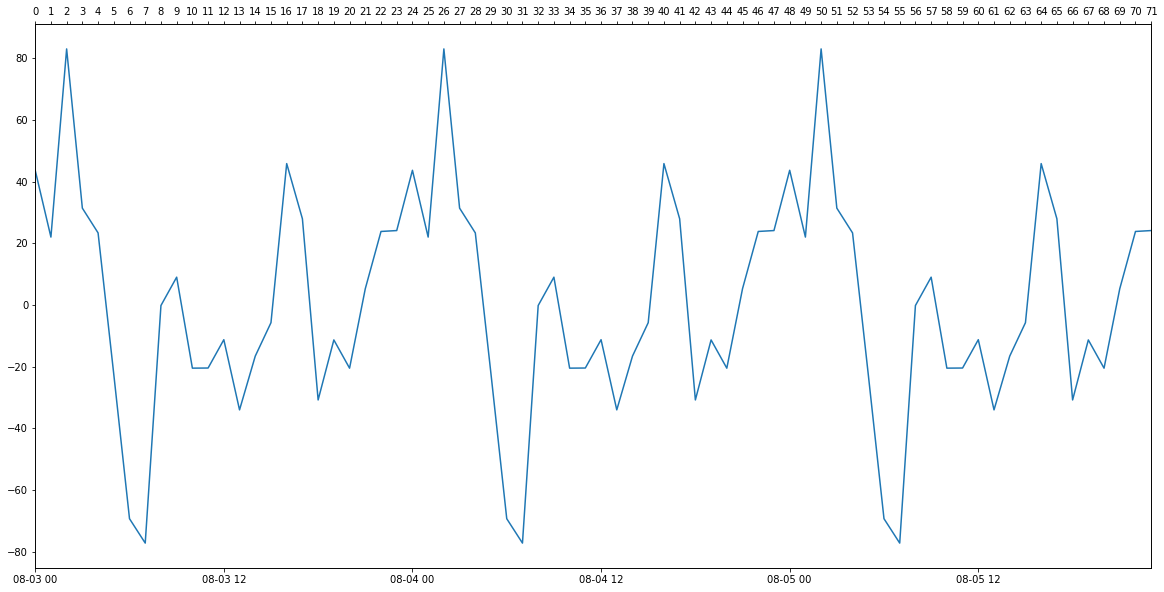

In [15]:
decomposed = seasonal_decompose(data['2018-08-03':'2018-08-05'])
Y = decomposed.seasonal['2018-08-03':'2018-08-05'].values
x = decomposed.seasonal['2018-08-03':'2018-08-05'].index
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax2.set_xticks(np.arange(len(x)), minor=False)

ax1.set_xlim(min(x), max(x))
ax1.plot(x, Y)


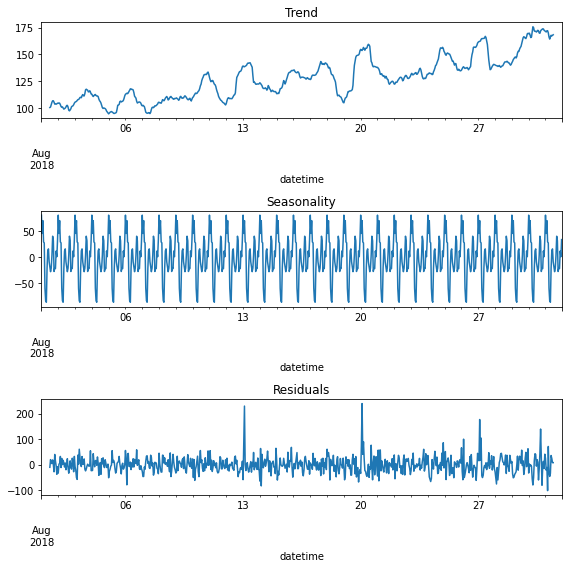

In [16]:
decomposed = seasonal_decompose(data['2018-08-01':'2018-08-31'])
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')


plt.tight_layout()    

1. Number of orders increases with time.
2. We can see peacks of orders in the middle of the night. (Taxi is the only was at 2 am)
3. The most oreders are on Fridays and Mondays. (People fly on the weekends and come back after)

## Training

***Base Models***

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1,random_state=123)
train = train.dropna()
train_y = train['num_orders']
train_X = train.drop('num_orders', axis=1)
test_y = test['num_orders']
test_X = test.drop('num_orders', axis=1)

In [18]:
#Constant median
pred_median = np.ones(test_y.shape) * train_y.median()
print('MAE:', mean_absolute_error(test_y, pred_median))
print('RMSE:', math.sqrt(mean_squared_error(test_y, pred_median)))

MAE: 70.7918552036199
RMSE: 87.15277582981295


In [19]:
#Previous value
pred_previous = test_y.shift()
pred_previous.iloc[0] = train_y.iloc[-1]
print('MAE:', mean_absolute_error(test_y, pred_previous))
print('RMSE:', math.sqrt(mean_squared_error(test_y, pred_previous)))

MAE: 44.97285067873303
RMSE: 58.856486242815066


***Feature Generation***

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [21]:
df=make_features(data, 10, 10)
df

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9


***Linear Regression***

In [22]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()
y_train = train['num_orders']
X_train = train.drop('num_orders', axis=1)
test_y = test['num_orders']
test_X = test.drop('num_orders', axis=1)

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(test_X)
print('RMSE on test:', math.sqrt(mean_squared_error(test_y, pred_test)))

RMSE on test: 47.91947872044137


In [24]:
def eval_regressor(y_true, y_pred):
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [25]:
rmse = make_scorer(eval_regressor, greater_is_better=False)

In [26]:
def train_fit_score(model, params, name):
    tscv = TimeSeriesSplit(n_splits=5)
    model = GridSearchCV(model, param_grid=params, cv=tscv, scoring=rmse, verbose=0, refit=True)
    model.fit(X_train, y_train)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns=['Estimator', 'Best Score', 'Best Params'])

In [30]:
%%time
#Create Linear Regressor
LinearRegressor = train_fit_score(LinearRegression(), {}, 'Linear Regressor')

CPU times: user 60.1 ms, sys: 42.9 ms, total: 103 ms
Wall time: 77.4 ms


In [31]:
LinearRegressor

,Estimator,Best Score,Best Params
0,Linear Regressor,29.957959,{}


In [32]:
%%time
cbr = train_fit_score(CatBoostRegressor(random_state=12345), 
                       {'depth': [6,10],
                        'iterations': [50,100]},'CatBoost')

Learning rate set to 0.429894
0:	learn: 24.0744300	total: 48.1ms	remaining: 2.36s
1:	learn: 20.9666489	total: 49.5ms	remaining: 1.19s
2:	learn: 19.0660017	total: 51.6ms	remaining: 808ms
3:	learn: 18.5657041	total: 53.7ms	remaining: 617ms
4:	learn: 17.6856224	total: 55.7ms	remaining: 502ms
5:	learn: 16.9821809	total: 57.9ms	remaining: 425ms
6:	learn: 16.3248428	total: 59.2ms	remaining: 363ms
7:	learn: 16.0013933	total: 60.5ms	remaining: 318ms
8:	learn: 15.5929609	total: 61.9ms	remaining: 282ms
9:	learn: 15.0477739	total: 63.3ms	remaining: 253ms
10:	learn: 14.7260066	total: 65.4ms	remaining: 232ms
11:	learn: 14.3836290	total: 66.8ms	remaining: 211ms
12:	learn: 14.1470077	total: 68.2ms	remaining: 194ms
13:	learn: 13.7702677	total: 69.5ms	remaining: 179ms
14:	learn: 13.5805818	total: 70.9ms	remaining: 166ms
15:	learn: 13.3883384	total: 72.3ms	remaining: 154ms
16:	learn: 13.0415902	total: 73.6ms	remaining: 143ms
17:	learn: 12.8228710	total: 74.8ms	remaining: 133ms
18:	learn: 12.4325067	tota

In [33]:
cbr

,Estimator,Best Score,Best Params
0,CatBoost,24.78941,"{'depth': 6, 'iterations': 100}"


In [34]:
%%time
xgbr = train_fit_score(xgb.XGBRegressor(random_state=12345), 
                       {'max_depth': [6,10],
                        'n_estimators': range(100, 300,100)},'XGBoost')

CPU times: user 4min 31s, sys: 1.78 s, total: 4min 33s
Wall time: 4min 36s


In [35]:
xgbr

,Estimator,Best Score,Best Params
0,XGBoost,25.433632,"{'max_depth': 6, 'n_estimators': 100}"


In [36]:
scores_gb = pd.concat([cbr, xgbr]).set_index('Estimator')
scores_gb['Best Score'] = scores_gb['Best Score'].round(2)
display(scores_gb.drop('Best Params', axis=1))

,Best Score
Estimator,
CatBoost,24.79
XGBoost,25.43


## Testing

In [37]:
pred_test = model.predict(test_X)
print('RMSE on test for Linear Regressor:', math.sqrt(mean_squared_error(test_y, pred_test)))

RMSE on test for Linear Regressor: 47.91947872044137


In [38]:
cbr_model = CatBoostRegressor(**scores_gb['Best Params'][0]).fit(X_train, y_train)

cbr_rmse = round(eval_regressor(test_y, cbr_model.predict(test_X)), 2)

#Print the result.
print(f'RMSE for best CatBoost model on test datasets: {cbr_rmse}')

Learning rate set to 0.324767
0:	learn: 31.2057636	total: 3.23ms	remaining: 320ms
1:	learn: 27.8310151	total: 5.71ms	remaining: 280ms
2:	learn: 26.0821355	total: 8.34ms	remaining: 270ms
3:	learn: 24.5705566	total: 11.1ms	remaining: 266ms
4:	learn: 23.7349893	total: 14.8ms	remaining: 282ms
5:	learn: 23.3202216	total: 18.2ms	remaining: 285ms
6:	learn: 22.7672698	total: 20.5ms	remaining: 273ms
7:	learn: 22.4944725	total: 22.8ms	remaining: 262ms
8:	learn: 22.2417510	total: 25ms	remaining: 253ms
9:	learn: 21.9634664	total: 27.4ms	remaining: 246ms
10:	learn: 21.7557695	total: 30.7ms	remaining: 249ms
11:	learn: 21.4005376	total: 33.6ms	remaining: 246ms
12:	learn: 21.1277688	total: 35.7ms	remaining: 239ms
13:	learn: 20.9582070	total: 37.9ms	remaining: 233ms
14:	learn: 20.7777207	total: 40.1ms	remaining: 227ms
15:	learn: 20.7254784	total: 42.6ms	remaining: 224ms
16:	learn: 20.6659787	total: 44.8ms	remaining: 219ms
17:	learn: 20.5113931	total: 47.2ms	remaining: 215ms
18:	learn: 20.2977960	total:

In [39]:
xgbr_model = xgb.XGBRegressor(**scores_gb['Best Params'][1]).fit(X_train, y_train)


xgbr_rmse = round(eval_regressor(test_y, xgbr_model.predict(test_X)), 2)

#Print the result.
print(f'RMSE for best XGBoost model on test datasets: {xgbr_rmse}')

RMSE for best XGBoost model on test datasets: 43.46


XGBoost model showed the best RMSE result. It significantly better than the base model.


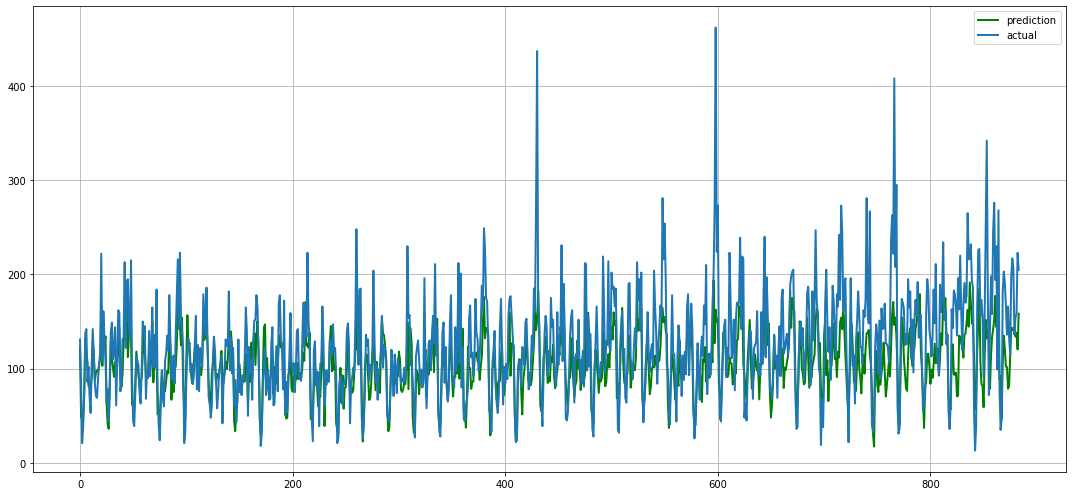

In [63]:
prediction = xgbr_model.predict(test_X)

plt.figure(figsize=(15, 7))
plt.plot(prediction, "g", label="prediction", linewidth=2.0)
plt.plot(test_y.values, label="actual", linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)

It seems like predictions can be following rolling mean but the model can't predict the anomalies.